# Overview

This script performs the causal network guided MLR analysis from Cosford et al.

The different steps include:
- loading the modules
- opening and plotting the time-series (and print the stds, and 2020/21 values)
- performing the MLR analysis and show the 2020/21 predictions
- show the trend estimates (CAT, UB, GMT)


## 1) load modules, specify parameters, functions for preprocessing

### Modules

In [84]:
#=============================
# Import modules
#=============================
import numpy as np
import xarray as xr
import cartopy
import cartopy.crs as ccrs
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline 
#import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.cm as cm
import scipy
from scipy.stats import linregress

import statsmodels.api as sm
import pandas as pd
import math

### Parameters

In [85]:
#=============================
# Parameters
#=============================
start_year = 1979 
end_year = 2021 

# OND
months_BKS = [10, 11, 12]
months_UB = [10, 11, 12]
months_NP = [10, 11, 12]

#JFM
months_SPV = [1, 2, 3]
months_CAT = [1, 2, 3]


# save path
save_path = "/climca/people/mkretschmer/2024_Cosford_etal/figures/"


### Functions

In [86]:
def get_season_year(ds):
    return xr.DataArray(
        ds['time.year'],  # No adjustment for December
        dims='time'
    )


def remove_trend_over_ref_period(X_anomalies):
    """
    Calculate the trend over all but the last year (the ref period) and then remove it from all years

    """
    years_all = X_anomalies.year.values  # All years
    
    start_year = years_all[0]
    end_year = years_all[-1]

    # all year but the last one:
    X_anomalies_reference_period = X_anomalies.sel(year=slice(start_year, end_year - 1))  # Data during reference period
    years_reference_period = X_anomalies_reference_period.year.values  # Corresponding years for reference period
    
    # Compute slope and intercept over the reference period
    slope, intercept, _, _, _ = linregress(years_reference_period, X_anomalies_reference_period)

    # Remove the trend from all years (including the last one) to get the detrended data
    X_det = X_anomalies - (slope * years_all + intercept)
    
    return X_det
    



def process(X, list_months, start_year = start_year, end_year = end_year):

    """
    Function to pre-process the data. 
    # NB: all the processing will be performed over start_year to end_year - 1 
    
    Returns:
        - X_det_scaled, the standardies detrended time-series 
        - X_trend_scaled, the standardiestrended time-series 
        - year_std_det, the std of the detrended time-series, used to standardise the time-series 
    """
    

    # Remove lon and lat variables (coordinates) if they exist
    if 'lon' in X.coords and 'lat' in X.coords:
        X = X.drop_vars(['lon', 'lat'])

   
    # Select the months provided in list_months
    X_selected_months = X.sel(time=X.time.dt.month.isin(list_months))
    
    # Now compute the season year on the selected months to ensure alignment
    season_year = get_season_year(X_selected_months)

    # Group by adjusted "season year" and calculate mean over the selected months
    X_season_avg = X_selected_months.groupby(season_year).mean(dim='time')

    # Rename the 'group' coordinate to 'year'
    #X_season_avg = X_season_avg.rename({'group': 'year'})
    
    # Remove 'lat' and 'lon' dimensions if they are size 1
    X_season_avg = X_season_avg.squeeze(drop=True)


    # If start_year and end_year are provided, filter the DataArray to include only these years
    if start_year is not None and end_year is not None:
        X_season_avg = X_season_avg.sel(year=slice(start_year, end_year))



    #====================================
    # 1)'''CALCLATE THE ANOMALY'''
    #====================================

    # Calculate the mean across the 'year' dimension # minus last year
    year_mean = X_season_avg.sel(year=slice(start_year, end_year-1)).mean(dim='year')

    # Remove the mean at each time-step
    X_anomalies = X_season_avg - year_mean
    
    #====================================
    # 2) '''DETREND THE DATA'''
    #====================================
    # Apply the trend removal function
    X_det = remove_trend_over_ref_period(X_anomalies)

    #====================================
    # 3a)  standardize detrended data
    #====================================
    year_std_det = X_det.sel(year=slice(start_year, end_year-1)).std(dim='year')
    X_det_scaled = X_det/year_std_det

    #====================================
    # 3b )  '''SCALED STANDARDISED TRENDED DATA'''
    #====================================
    X_trend_scaled = X_anomalies/year_std_det
       
  
    return X_det_scaled, X_trend_scaled, year_std_det.item()



## 2) Open the Time-series and plot them

In [87]:
# ==================================
# open data
# ==================================

# ==============
# BKS: Barents Kara sea ice
# ==============
bks = xr.open_dataset("/climca/people/mkretschmer/2024_Cosford_etal/data/BKSIF_index_monthly_1940-2023.nc")["CI"]
BKS_det, BKS_trended, BKS_std = process(bks, months_BKS, start_year= 1979, end_year = 2020)

# ==============
# UB: Ural blocking
# ==============
ub = xr.open_dataset("/climca/people/mkretschmer/2024_Cosford_etal/data/UB_index_monthly_1940-2023.nc")["var151"]
UB_det, UB_trended, UB_std = process(ub, months_UB, start_year= 1979, end_year = 2020)

# ==============
# NP: North Pacific blocking
# ==============
np = xr.open_dataset("/climca/people/mkretschmer/2024_Cosford_etal/data/NP_index_monthly_1940-2023.nc")["var151"]
NP_det, NP_trended, NP_std = process(np, months_NP, start_year= 1979, end_year = 2020)


# ==============
# SPV
# ==============
spv = xr.open_dataset("/climca/people/mkretschmer/2024_Cosford_etal/data/SPV_index_monthly_u10_55-65N_1940-2023.nc")["var131"]
SPV_det, SPV_trended, SPV_std = process(spv, months_SPV, start_year= 1980, end_year = 2021)


# ==============
# CAT: Central Asia temperature
# ==============
cat = xr.open_dataset("/climca/people/mkretschmer/2024_Cosford_etal/data/CAT_index_monthly_1940-2023.nc")["var167"]
CAT_det, CAT_trended, CAT_std = process(cat, months_CAT, start_year= 1980, end_year = 2021)


# ==============
# GMT: Global mean temperature
# ==============
gmt = xr.open_dataset("/climca/people/mkretschmer/2024_Cosford_etal/data/GMT_index_monthly_1940-2023.nc")["var167"]
GMT_det, GMT_trended, GMT_std = process(gmt, months_CAT, start_year= 1980, end_year = 2021)

### Plot the time-series

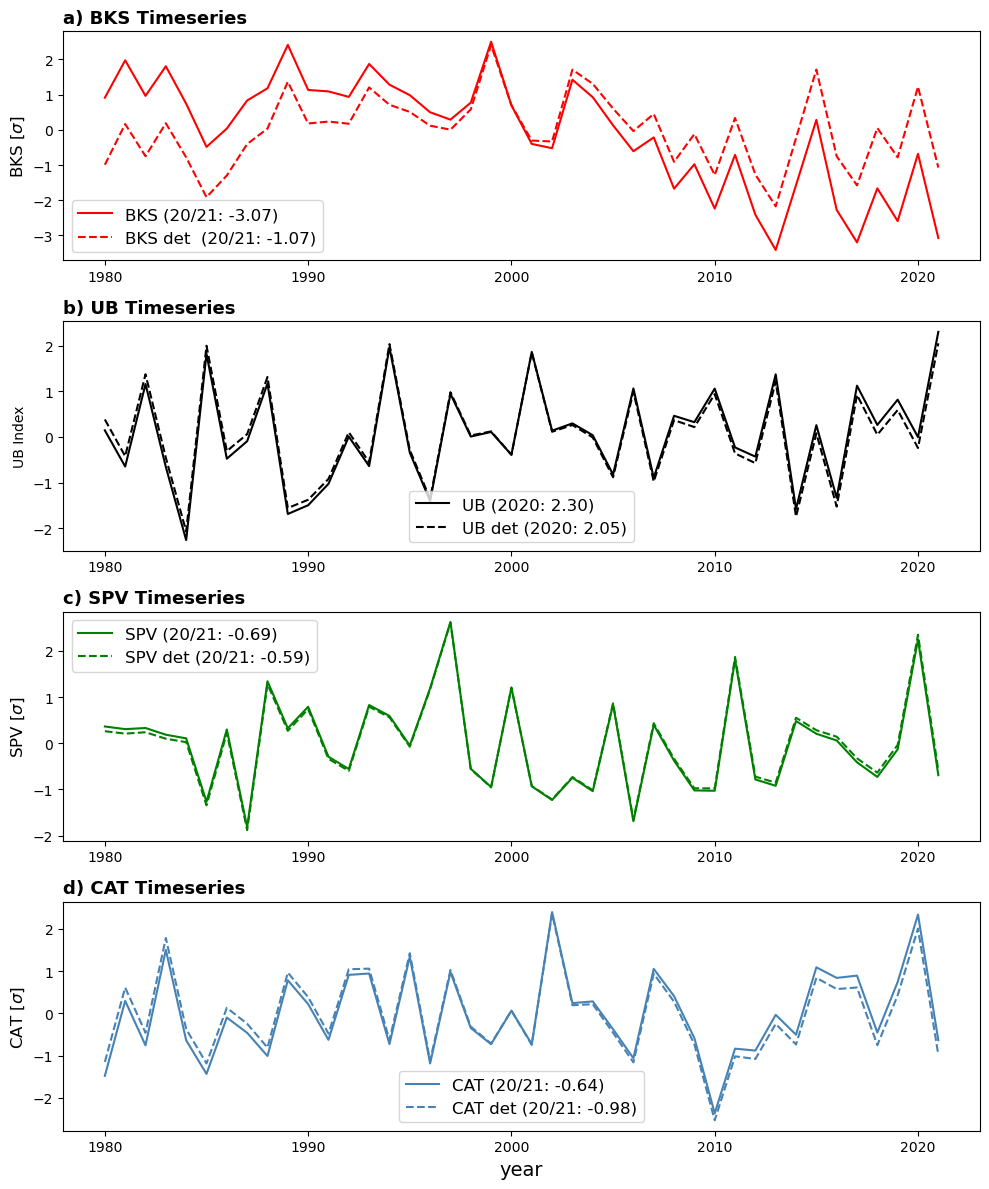

In [96]:
#======================================
# Create the figure and subplots
#======================================
fig, axes = plt.subplots(4, 1, figsize=(10, 12))

years = CAT_det['year'] # 1980 - 2021

# Plot BSIF timeseries
ax = axes[0]

ax.plot(years, BKS_trended, label=f'BKS (20/21: {BKS_trended[-1].data:.2f})', color='red')
ax.plot(years, BKS_det, label=f'BKS det  (20/21: {BKS_det[-1].data:.2f})', color='red', linestyle = "--")

ax.set_title('a) BKS Timeseries', loc = "left", fontweight='bold', fontsize = 13)
ax.set_ylabel('BKS [$\sigma$]', fontsize = 12)
ax.legend( fontsize = 12)


# Plot UB timeseries
ax = axes[1]
ax.plot(years, UB_trended, color="k", label=f'UB (2020: {UB_trended[-1].data:.2f})')
ax.plot(years, UB_det, label=f'UB det (2020: {UB_det[-1].data:.2f})', color="k", linestyle="--")
ax.set_title('b) UB Timeseries', loc = "left", fontweight='bold', fontsize = 13)
ax.set_ylabel('UB Index')
ax.legend( fontsize = 12)


# Plot SPV timeseries
ax = axes[2]
ax.plot(years, SPV_trended, color = "green", label=f'SPV (20/21: {SPV_trended[-1].data:.2f})')
ax.plot(years, SPV_det, label=f'SPV det (20/21: {SPV_det[-1].data:.2f})', color = "green", linestyle = "--")
ax.set_title('c) SPV Timeseries', loc = "left", fontweight='bold', fontsize = 13)
ax.set_ylabel('SPV [$\sigma$]', fontsize = 12)
ax.legend( fontsize = 12)


# Plot CAT timeseries
ax = axes[3]
ax.plot(years, CAT_trended, color="steelblue", label=f'CAT (20/21: {CAT_trended[-1].data:.2f})')
ax.plot(years, CAT_det, label=f'CAT det (20/21: {CAT_det[-1].data:.2f})', color="steelblue", linestyle="--")
ax.set_title('d) CAT Timeseries', loc = "left", fontweight='bold', fontsize = 13)
ax.set_ylabel('CAT [$\sigma$]', fontsize = 12)
ax.legend( fontsize = 12)


# Final adjustments
plt.xlabel('year', fontsize = 14)
plt.tight_layout()

fig.tight_layout()

# save figure

plt.savefig(save_path + "timeseries_withUB.png")

### Print the standard deviations of the time-series



In [89]:
from IPython.display import Markdown, display

markdown_text = f"""
<p style='font-size:22px;'>
<b>Standard deviations of the detrended time-series:</b>
</p>
<ul style='font-size:20px;'>
- The std of the detrended BKS timeseries is <b>{BKS_std:.2f}</b>.<br>
- The std of the detrended SPV timeseries is <b>{SPV_std:.2f}</b>.<br>
- The std of the detrended CAT timeseries is <b>{CAT_std:.2f}</b>.<br>
- The std of the detrended UB timeseries is <b>{UB_std:.2f}</b>.<br>
- The std of the detrended NP timeseries is <b>{NP_std:.2f}</b>.<br>
</ul>
"""

display(Markdown(markdown_text))


<p style='font-size:22px;'>
<b>Standard deviations of the detrended time-series:</b>
</p>
<ul style='font-size:20px;'>
- The std of the detrended BKS timeseries is <b>0.06</b>.<br>
- The std of the detrended SPV timeseries is <b>8.22</b>.<br>
- The std of the detrended CAT timeseries is <b>2.03</b>.<br>
- The std of the detrended UB timeseries is <b>260.91</b>.<br>
- The std of the detrended NP timeseries is <b>213.06</b>.<br>
</ul>


### Print the values of winter 2020/21

In [90]:
year = 2020

BKS_2020_trended = BKS_trended.sel(year=year).item()
BKS_2020_det = BKS_det.sel(year=year).item()

SPV_2021_trended = SPV_trended.sel(year=year +1).item()
SPV_2021_det = SPV_det.sel(year=year+1).item()

CAT_2021_trended = CAT_trended.sel(year=year +1).item()
CAT_2021_det = CAT_det.sel(year=year +1).item()

UB_2020_trended = UB_trended.sel(year=year).item()
UB_2020_det = UB_det.sel(year=year).item()

NP_2020_trended = NP_trended.sel(year=year).item()
NP_2020_det = NP_det.sel(year=year).item()

markdown_text = f"""
<p style='font-size:22px;'>
<b>Detrended data:</b>
</p>
<ul style='font-size:20px;'>
- The 2020/21 BKS value was <b>{BKS_2020_det:.2f}</b> --> in physical units: <b>{BKS_2020_det*BKS_std:.2f}</b>.<br>
- The 2020/21 SPV value was <b>{SPV_2021_det:.2f}</b> --> in physical units: <b>{SPV_2021_det*SPV_std:.2f}</b>.<br>
- The 2020/21 CAT value was <b>{CAT_2021_det:.2f}</b> --> in physical units: <b>{CAT_2021_det*CAT_std:.2f}</b>.<br>
- The 2020/21 UB value was <b>{UB_2020_det:.2f}</b> --> in physical units: <b>{UB_2020_det*UB_std:.2f}</b>.<br>
- The 2020/21 NP value was <b>{NP_2020_det:.2f}</b> --> in physical units: <b>{NP_2020_det*NP_std:.2f}</b>.<br>
</ul>

<p style='font-size:22px;'>
<b>Trended data:</b>
</p>
<ul style='font-size:20px;'>
- The 2020/21 BKS value was <b>{BKS_2020_trended:.2f}</b>--> in physical units: <b>{BKS_2020_trended*BKS_std:.2f}</b>.<br>
- The 2020/21 SPV value was <b>{SPV_2021_trended:.2f}</b>--> in physical units: <b>{SPV_2021_trended*SPV_std:.2f}</b>.<br>
- The 2020/21 CAT value was <b>{CAT_2021_trended:.2f}</b>--> in physical units: <b>{CAT_2021_trended*CAT_std:.2f}</b>.<br>
- The 2020/21 UB value was <b>{UB_2020_trended:.2f}</b> --> in physical units: <b>{UB_2020_trended*UB_std:.2f}</b>.<br>
- The 2020/21 NP value was <b>{NP_2020_trended:.2f}</b> --> in physical units: <b>{NP_2020_trended*NP_std:.2f}</b>.<br>

</ul>

"""

display(Markdown(markdown_text))


<p style='font-size:22px;'>
<b>Detrended data:</b>
</p>
<ul style='font-size:20px;'>
- The 2020/21 BKS value was <b>-1.07</b> --> in physical units: <b>-0.07</b>.<br>
- The 2020/21 SPV value was <b>-0.59</b> --> in physical units: <b>-4.81</b>.<br>
- The 2020/21 CAT value was <b>-0.98</b> --> in physical units: <b>-2.00</b>.<br>
- The 2020/21 UB value was <b>2.05</b> --> in physical units: <b>535.08</b>.<br>
- The 2020/21 NP value was <b>-0.57</b> --> in physical units: <b>-121.00</b>.<br>
</ul>

<p style='font-size:22px;'>
<b>Trended data:</b>
</p>
<ul style='font-size:20px;'>
- The 2020/21 BKS value was <b>-3.07</b>--> in physical units: <b>-0.20</b>.<br>
- The 2020/21 SPV value was <b>-0.69</b>--> in physical units: <b>-5.69</b>.<br>
- The 2020/21 CAT value was <b>-0.64</b>--> in physical units: <b>-1.29</b>.<br>
- The 2020/21 UB value was <b>2.30</b> --> in physical units: <b>600.34</b>.<br>
- The 2020/21 NP value was <b>-0.12</b> --> in physical units: <b>-24.56</b>.<br>

</ul>



## 3) MLR analysis

In [91]:
# use the detrended data for the MLR analysis
# Exclude the last year from all datasets for the MLR analysis

data = pd.DataFrame({
    'CAT_det': CAT_det[:-1].values,
    'BKS_det': BKS_det[:-1].values,
    'SPV_det': SPV_det[:-1].values,
    'UB_det': UB_det[:-1].values,
    'NP_det': NP_det[:-1].values
})


# ===================================================================
# Equation 1: CAT_det = a BSIF_det + b SPV_det + c UB_det
# ===================================================================
X1 = data[['BKS_det', 'SPV_det', 'UB_det']]  # Independent variables
y1 = data['CAT_det']  # Dependent variable

model_1 = sm.OLS(y1, X1).fit()  # Fit the model

# Access coefficients and standard errors
a1, b1, c1 = model_1.params['BKS_det'], model_1.params['SPV_det'], model_1.params['UB_det']
se_a1, se_b1, se_c1 = model_1.bse['BKS_det'], model_1.bse['SPV_det'], model_1.bse['UB_det']


# ================================================
# Equation 2: SPV_det = a BSIF_det + b NP_det + c UB_det
# ================================================
X2 = data[['BKS_det', 'NP_det', 'UB_det']]  # Independent variables
y2 = data['SPV_det']  # Dependent variable

model_2 = sm.OLS(y2, X2).fit()  # Fit the model


# Access coefficients and standard errors
a2, b2, c2 = model_2.params['BKS_det'], model_2.params['NP_det'], model_2.params['UB_det']
se_a2, se_b2, se_c2 = model_2.bse['BKS_det'], model_2.bse['NP_det'], model_2.bse['UB_det']


# ======================================================
# Equation 3: Tropo + Strato
# ======================================================

a3 = a1 + a2 * b1

# Compute standard errors using error propagation
se_a2_times_b1 = math.sqrt((b1 * se_a2)**2 + (a2 * se_b1)**2)  # Error propagation

# Standard error of both pathways
se_a3 = math.sqrt(se_a1**2 + se_a2_times_b1**2)  # Sum of variances



# ======================================================
# Equation 4: CAT_det = a BSIF_det + b NP_det + c UB_det
# ======================================================
X4 = data[['BKS_det',  'NP_det', 'UB_det']]  # Independent variables
y4 = data['CAT_det']  # Dependent variable

model_4 = sm.OLS(y4, X4).fit()  # Fit the model

# Access coefficients and standard errors
a4, b4, c4 = model_4.params['BKS_det'], model_4.params['NP_det'], model_4.params['UB_det']
se_a4, se_b4, se_c4 = model_4.bse['BKS_det'], model_4.bse['NP_det'], model_4.bse['UB_det']


# ======================================================
# print results as markdown text
# ======================================================

markdown_text = f"""
<p style='font-size:22px;'>
<b>Equation 1:</b> CAT_det = a1 * BKS_det + b1 * SPV_det + c1 * UB_det
</p>
<ul style='font-size:20px;'>
a1 =  {a1:.2f} ± {se_a1:.2f} &nbsp; --> this is the tropo pathway effect strength from BKS to CAT </b><br>
b1 =  {b1:.2f} ± {se_b1:.2f} &nbsp; --> this is the downward effect strength from SPV to CAT </b><br>
c1 =  {c1:.2f} ± {se_c1:.2f}</b><br>

</ul>


<p style='font-size:22px;'>
<b>Equation 2:</b> SPV_det = a2 * BKS_det + b2 * NP_det + c3 * UB_det
</p>
<ul style='font-size:20px;'>
a2 =  {a2:.2f} ± {se_a2:.2f} &nbsp;--> this is the upward effect strength from BK to SPV </b><br>
b2 =  {b2:.2f} ± {se_b2:.2f}</b><br>
c3 =  {c2:.2f} ± {se_c2:.2f}</b><br>

</ul>

<p style='font-size:22px;'>
<b>Equation 3:</b> a3 = tropo pathway + strato pathway = a1 + a2 * b1
</p>
<ul style='font-size:20px;'>
a2 * b1 = {a2 * b1:.2f} ± {se_a2_times_b1:.2f} &nbsp;--> this is the strength of the strato pathway </b><br>
a3 =  {a1 + a2 * b1:.2f} ± {se_a3:.2f} &nbsp;--> this is the sum of the strengthes of both pathways </b><br>
</ul>


<p style='font-size:22px;'>
<b>Equation 4:</b> CA_det = a4 * BKS_det + b4 * NP_det + c4 * UB_det
</p>
<ul style='font-size:20px;'>
a4 =  {a4:.2f} ± {se_a4:.2f} --> this is the total effect strength from BKS to CAT (without distinguishing between pathways) </b><br>
b4 =  {b4:.2f} ± {se_b4:.2f}</b><br>
c4=  {c4:.2f} ± {se_c4:.2f}</b><br>

</ul>

"""
display(Markdown(markdown_text))



<p style='font-size:22px;'>
<b>Equation 1:</b> CAT_det = a1 * BKS_det + b1 * SPV_det + c1 * UB_det
</p>
<ul style='font-size:20px;'>
a1 =  0.23 ± 0.16 &nbsp; --> this is the tropo pathway effect strength from BKS to CAT </b><br>
b1 =  0.15 ± 0.16 &nbsp; --> this is the downward effect strength from SPV to CAT </b><br>
c1 =  -0.14 ± 0.16</b><br>

</ul>


<p style='font-size:22px;'>
<b>Equation 2:</b> SPV_det = a2 * BKS_det + b2 * NP_det + c3 * UB_det
</p>
<ul style='font-size:20px;'>
a2 =  0.22 ± 0.15 &nbsp;--> this is the upward effect strength from BK to SPV </b><br>
b2 =  0.24 ± 0.15</b><br>
c3 =  -0.16 ± 0.16</b><br>

</ul>

<p style='font-size:22px;'>
<b>Equation 3:</b> a3 = tropo pathway + strato pathway = a1 + a2 * b1
</p>
<ul style='font-size:20px;'>
a2 * b1 = 0.03 ± 0.04 &nbsp;--> this is the strength of the strato pathway </b><br>
a3 =  0.27 ± 0.16 &nbsp;--> this is the sum of the strengthes of both pathways </b><br>
</ul>


<p style='font-size:22px;'>
<b>Equation 4:</b> CA_det = a4 * BKS_det + b4 * NP_det + c4 * UB_det
</p>
<ul style='font-size:20px;'>
a4 =  0.25 ± 0.16 --> this is the total effect strength from BKS to CAT (without distinguishing between pathways) </b><br>
b4 =  -0.13 ± 0.15</b><br>
c4=  -0.20 ± 0.16</b><br>

</ul>



### now predict the 2020/21 values


<p style='font-size:22px;'>
<b>a) Detrended data:</b> 
</p>
<ul style='font-size:20px;'>
Observed CAT = -0.98 </b><br>
predicted CAT (tropo + strato) =  -0.29 ± 0.18 </b><br>
predicted CAT (via tropo) =  -0.25 ± 0.17 </b><br>
predicted CAT (via strato) =  -0.04 ± 0.05 </b><br>
Obs-Pred = -0.70
</ul>


<p style='font-size:22px;'>
<b>b) Trended data:</b> 
</p>
<ul style='font-size:20px;'>
Observed CAT = -0.98 </b><br>
predicted CAT (tropo + strato) =  -0.82 ± 0.50 </b><br>
predicted CAT (via tropo) =  -0.71 ± 0.49 </b><br>
predicted CAT (via strato) =  -0.10 ± 0.13 </b><br>
Obs-Pred = 0.18
</ul>



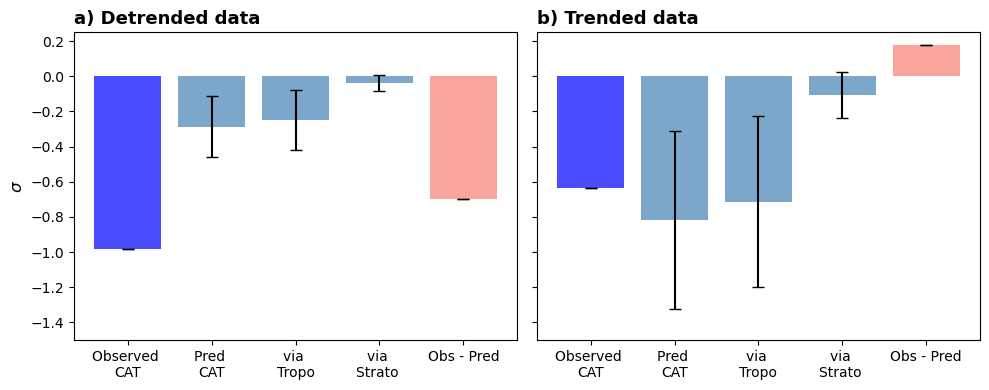

In [92]:
#============================================
# now predict the 2020/21 values
#============================================
# via topo pathway
pred_CA_trended_tropo = BKS_2020_trended  * a1 
pred_CA_det_tropo = BKS_2020_det * a1 

# via strato  pathway
pred_CA_trended_strato = BKS_2020_trended  * (a2 * b1)
pred_CA_det_strato = BKS_2020_det * (a2 * b1) 

# via tropo + strato pathways
pred_CA_trended = BKS_2020_trended  * a3 
pred_CA_det = BKS_2020_det  *  a3 


#============================================
# standard errors for 2020/21 predictions
#============================================

# Standard errors for detrended data
se_pred_CA_det_tropo = abs(BKS_2020_det) * se_a1
se_pred_CA_det_strato = abs(BKS_2020_det) * se_a2_times_b1
se_pred_CA_det = abs(BKS_2020_det) * se_a3


# Standard errors for trended data
se_pred_CA_trended_tropo = abs(BKS_2020_trended) * se_a1
se_pred_CA_trended_strato = abs(BKS_2020_trended) * se_a2_times_b1
se_pred_CA_trended = abs(BKS_2020_trended) * se_a3

#============================================
# Data to plot
#============================================
labels = ["Observed \nCAT", "Pred \nCAT", "via \nTropo", "via \nStrato ", "Obs - Pred"]

# Data for barplot
data1 = [CAT_2021_det, pred_CA_det, pred_CA_det_tropo, pred_CA_det_strato, CAT_2021_det - pred_CA_det]
data2 = [CAT_2021_trended, pred_CA_trended, pred_CA_trended_tropo, pred_CA_trended_strato, CAT_2021_trended- pred_CA_trended]

# Errors for the bar plots
errors1 = [0, se_pred_CA_det, se_pred_CA_det_tropo, se_pred_CA_det_strato, 0]
errors2 = [0, se_pred_CA_trended, se_pred_CA_trended_tropo, se_pred_CA_trended_strato, 0]



#============================================
# Create the barplot
#============================================
fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Plot for the first dataset (Detrended data)
bars1 = ax[0].bar(
    labels, data1, color=["blue", "steelblue", "steelblue", "steelblue", "salmon"], alpha=0.7, yerr=errors1, capsize=4
)
ax[0].set_ylim(-1.5, 0.25)
ax[0].set_title("a) Detrended data", loc = "left", fontweight='bold', fontsize = 13)
ax[0].set_ylabel("$\sigma$", fontsize = 12)

# Plot for the second dataset (Trended data)
bars2 = ax[1].bar(
    labels, data2, color=["blue", "steelblue", "steelblue", "steelblue", "salmon"], alpha=0.7, yerr=errors2, capsize=4
)
ax[1].set_ylim(-1.5, 0.25)
ax[1].set_title("b) Trended data", loc = "left", fontweight='bold', fontsize = 13)

# Adjust layout
fig.tight_layout()

# Show the plot
fig.tight_layout()

# save figure
fig.savefig(save_path + "barplot_predictions_2020_21")




# ======================================================
# print results as markdown text
# ======================================================

markdown_text = f"""
<p style='font-size:22px;'>
<b>a) Detrended data:</b> 
</p>
<ul style='font-size:20px;'>
Observed CAT = {CAT_2021_det:.2f} </b><br>
predicted CAT (tropo + strato) =  {pred_CA_det:.2f} ± {se_pred_CA_det:.2f} </b><br>
predicted CAT (via tropo) =  {pred_CA_det_tropo:.2f} ± {se_pred_CA_det_tropo:.2f} </b><br>
predicted CAT (via strato) =  {pred_CA_det_strato:.2f} ± {se_pred_CA_det_strato:.2f} </b><br>
Obs-Pred = {CAT_2021_det -pred_CA_det :.2f}
</ul>


<p style='font-size:22px;'>
<b>b) Trended data:</b> 
</p>
<ul style='font-size:20px;'>
Observed CAT = {CAT_2021_det:.2f} </b><br>
predicted CAT (tropo + strato) =  {pred_CA_trended:.2f} ± {se_pred_CA_trended:.2f} </b><br>
predicted CAT (via tropo) =  {pred_CA_trended_tropo:.2f} ± {se_pred_CA_trended_tropo:.2f} </b><br>
predicted CAT (via strato) =  {pred_CA_trended_strato:.2f} ± {se_pred_CA_trended_strato:.2f} </b><br>
Obs-Pred = {CAT_2021_trended -pred_CA_trended :.2f}
</ul>

"""
display(Markdown(markdown_text))



## 4) Time-series trends and trend contribution


<p style='font-size:22px;'>
<b> Trend statistics:</b> 
</p>
<ul style='font-size:20px;'>
Observed Trend: slope = 0.013, intercept = -26.554 </b><br>
Predicted Trend: slope = -0.026, intercept = 52.582 </b><br>

Observed warming over 42 years = 0.013 * 42 = 0.557 --> = 1.130 in physical units </b><br>
Predicted warming over 42 years = -0.026 * 42 = -1.104--> = -2.239 in physical units  </b><br>

</ul>




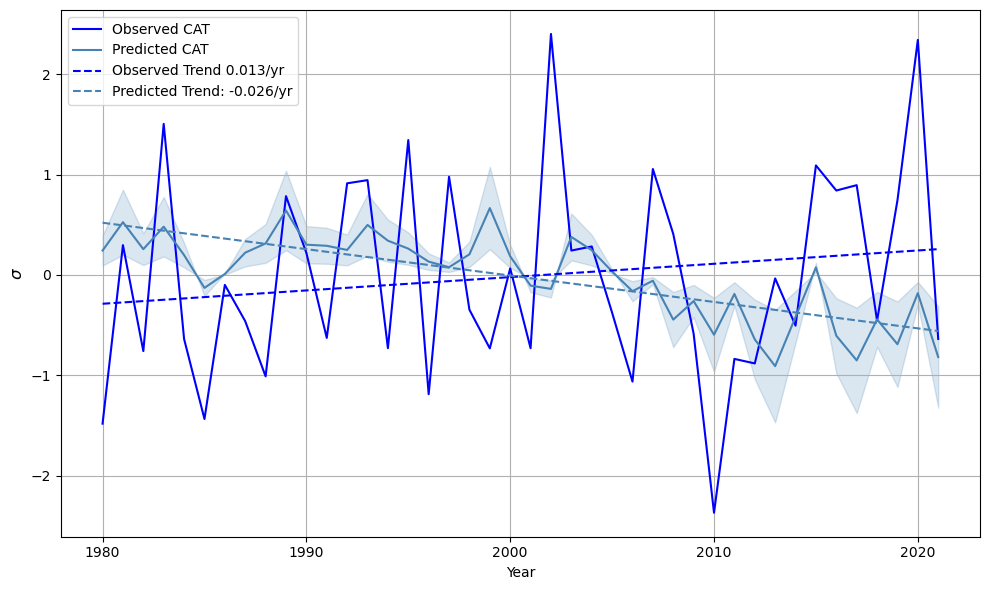

In [93]:
# Predicted time series and uncertainty
predicted = a3 * BKS_trended
predicted_upper = (a3 + se_a3) * BKS_trended
predicted_lower = (a3 - se_a3) * BKS_trended

# Fit trend lines
predicted_slope, predicted_intercept, _, _, _ = linregress(years, predicted)
actual_slope, actual_intercept, _, _, _ = linregress(years, CAT_trended)

# Create trend lines
predicted_trend = predicted_slope * years + predicted_intercept
actual_trend = actual_slope * years + actual_intercept


# Plot
fig = plt.figure(figsize=(10, 6))


# Plot actual time series
plt.plot(years, CAT_trended, label='Observed CAT', color='blue')

# Plot predicted time series with uncertainty
plt.plot(years, predicted, label='Predicted CAT', color='steelblue')
plt.fill_between(years, predicted_lower, predicted_upper, color='steelblue', alpha=0.2)#, label='Uncertainty (SE)')


# Plot trend lines
plt.plot(years, actual_trend, label=f'Observed Trend {actual_slope:.3f}/yr', linestyle='--', color='blue')
plt.plot(years, predicted_trend, label=f'Predicted Trend: {predicted_slope:.3f}/yr', linestyle='--', color='steelblue')

# Add labels, legend, and title
plt.xlabel('Year')
plt.ylabel("$\sigma$", fontsize = 12)
#plt.title('Predicted and Observed Time Series with Trend Lines')
plt.legend()
plt.grid(True)


fig.tight_layout()

# save figure
fig.savefig(save_path + "predicted_and_observed_timeseries_with_trends")



# ======================================================
# print results as markdown text
# ======================================================

markdown_text = f"""
<p style='font-size:22px;'>
<b> Trend statistics:</b> 
</p>
<ul style='font-size:20px;'>
Observed Trend: slope = {actual_slope:.3f}, intercept = {actual_intercept:.3f} </b><br>
Predicted Trend: slope = {predicted_slope:.3f}, intercept = {predicted_intercept:.3f} </b><br>

Observed warming over 42 years = {actual_slope:.3f} * 42 = {actual_slope *42:.3f} --> = {actual_slope *42 * CAT_std:.3f} in physical units </b><br>
Predicted warming over 42 years = {predicted_slope:.3f} * 42 = {predicted_slope *42:.3f}--> = {predicted_slope *42 * CAT_std:.3f} in physical units  </b><br>

</ul>


"""
display(Markdown(markdown_text))


### UB trends


<p style='font-size:22px;'>
<b> UB trends:</b> 
</p>
<ul style='font-size:20px;'>
UB Trend: slope = 0.019, intercept = -37.400 </b><br>
UB change over 42 years = 0.019 * 42 = 0.786 </b><br>
correlation (BKS_det, UB_det) = -0.294 </b><br>
</ul>




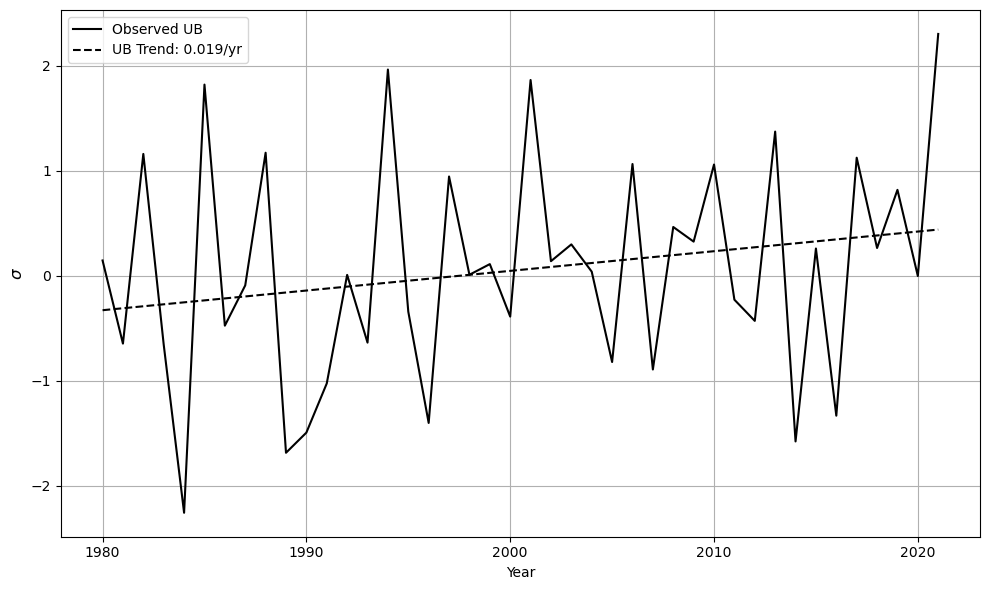

In [94]:
# ==============================
# trend in UB
# ==============================

# Fit trend lines
UB_slope, UB_intercept, _, _, _ = linregress(years, UB_trended)

# Create trend lines
UB_trend = UB_slope * years + UB_intercept

# Plot
fig = plt.figure(figsize=(10, 6))

# Plot actual time series
plt.plot(years, UB_trended, label='Observed UB', color='k')


# Plot trend lines
plt.plot(years, UB_trend, label=f'UB Trend: {UB_slope:.3f}/yr', linestyle='--', color='k')

# Add labels, legend, and title
plt.xlabel('Year')
plt.ylabel("$\sigma$", fontsize = 12)
#plt.title('Predicted and Observed Time Series with Trend Lines')
plt.legend()
plt.grid(True)


fig.tight_layout()

# save figure
fig.savefig(save_path + "UB_timeseries_with_trends")


# ======================================================
# correlation BKS and UB (detrended)
# ======================================================

correlation = xr.corr(UB_det, BKS_det, dim="year")

# ======================================================
# print results as markdown text
# ======================================================

markdown_text = f"""
<p style='font-size:22px;'>
<b> UB trends:</b> 
</p>
<ul style='font-size:20px;'>
UB Trend: slope = {UB_slope:.3f}, intercept = {UB_intercept:.3f} </b><br>
UB change over 42 years = {UB_slope:.3f} * 42 = {UB_slope *42:.3f} </b><br>
correlation (BKS_det, UB_det) = {correlation:.3f} </b><br>
</ul>


"""
display(Markdown(markdown_text))



# correlations
x = UB_det



<p style='font-size:22px;'>
<b> GMT (JFM) trends:</b> 
</p>
<ul style='font-size:20px;'>
GMT Trend: slope = 0.117, intercept = -233.389 </b><br>
GMT change over 42 years = 0.117 * 42 = 4.901 --> = 0.800 in physical units </b><br>
</ul>




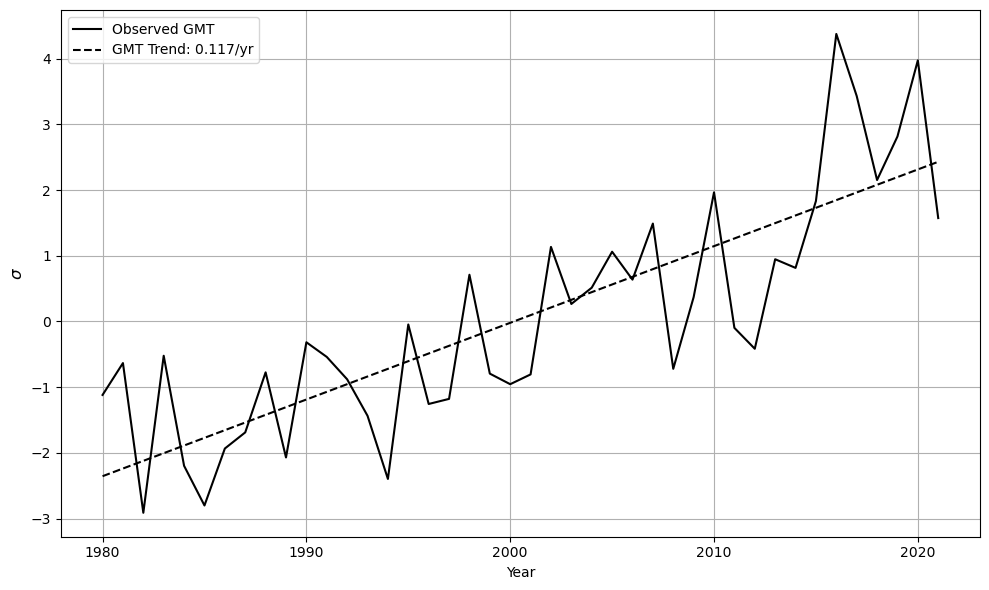

In [95]:
# ==============================
# GMT trends
# ==============================

# Fit trend lines
GMT_slope, GMT_intercept, _, _, _ = linregress(years, GMT_trended)

# Create trend lines
GMT_trend = GMT_slope * years + GMT_intercept

# Plot
fig = plt.figure(figsize=(10, 6))

# Plot actual time series
plt.plot(years, GMT_trended, label='Observed GMT', color='k')


# Plot trend lines
plt.plot(years, GMT_trend, label=f'GMT Trend: {GMT_slope:.3f}/yr', linestyle='--', color='k')

# Add labels, legend, and title
plt.xlabel('Year')
plt.ylabel("$\sigma$", fontsize = 12)
#plt.title('Predicted and Observed Time Series with Trend Lines')
plt.legend()
plt.grid(True)


fig.tight_layout()

# save figure
fig.savefig(save_path + "GMT_timeseries_with_trends")



# ======================================================
# print results as markdown text
# ======================================================

markdown_text = f"""
<p style='font-size:22px;'>
<b> GMT (JFM) trends:</b> 
</p>
<ul style='font-size:20px;'>
GMT Trend: slope = {GMT_slope:.3f}, intercept = {GMT_intercept:.3f} </b><br>
GMT change over 42 years = {GMT_slope:.3f} * 42 = {GMT_slope *42:.3f} --> = {GMT_slope *42 * GMT_std:.3f} in physical units </b><br>
</ul>


"""
display(Markdown(markdown_text))
